In [1]:
import copy
import pickle

import matplotlib as mpl
import numpy as np
import xarray as xa
from matplotlib import colorbar, colors
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

In [2]:
with open('TCNN_r2.pickle', 'rb') as handle:
    TCNN_r2 = pickle.load(handle)
with open('LSTM_r2.pickle', 'rb') as handle:
    LSTM_r2 = pickle.load(handle)
with open('ATT_r2.pickle', 'rb') as handle:
    ATT_r2 = pickle.load(handle)
print(len(TCNN_r2))
with open('UA_r2.pickle', 'rb') as handle:
    UA_r2 = pickle.load(handle)
print(len(UA_r2))

581
580


In [3]:
nsidc = xa.open_dataarray("NSIDC/SWES_CONUS.nc")
nsidc = nsidc.reindex(lat=nsidc.lat[::-1])
nsidc = nsidc.sel(time=slice("2009-03-30", "2018-09-30"))
print(nsidc.time[0], " ", nsidc.time[-1])
file = "SNOTEL/raw_wus_snotel_topo_clean.nc"
data = xa.open_dataset(file)
swe = data.SWE.sel(time=slice("2009-03-30", "2018-09-30"))

<xarray.DataArray 'time' ()>
array('2009-03-30T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2009-03-30
Attributes:
    long_name:  time   <xarray.DataArray 'time' ()>
array('2018-09-30T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2018-09-30
Attributes:
    long_name:  time


In [4]:
for i in range(581):
    station = data.isel(n_stations=i)
    lat = station.latitude.data
    lon = station.longitude.data
    abslat = np.abs(nsidc.lat - lat)
    latarg = np.where(abslat == np.min(abslat))[0][0]
    abslon = np.abs(nsidc.lon - lon)
    lonarg = np.where(abslon == np.min(abslon))[0][0]
    snotel_obs = swe[i]
    ua_pred = nsidc.isel(lat=latarg, lon=lonarg).data / 25.4  # mm to inch
    nan_id = np.where(np.isnan(snotel_obs))[0]
    snotel_obs = np.delete(snotel_obs, nan_id)
    ua_pred = np.delete(ua_pred, nan_id)
    nan_id = np.where(np.isnan(ua_pred))[0]
    snotel_obs = np.delete(snotel_obs, nan_id)
    ua_pred = np.delete(ua_pred, nan_id)
    if len(snotel_obs) < 2:
        print(i)
        break

237


In [5]:
def search_swe(x, l, r, bins):
    mid = int((l+r)/2)
    # print(l, mid, r)
    if x>=bins[mid] and x<bins[mid+1]:
        # print(mid, ' !')
        return mid
    elif x>bins[mid]:
        return search_swe(x, mid, r, bins)
    elif x<bins[mid]:
        return search_swe(x, l, mid, bins)

# Elevation

In [6]:
DL_height = data.elevation_prism.data
print(DL_height.shape)
UA_height = np.delete(DL_height, 237)
print(UA_height.shape)

(581,)
(580,)


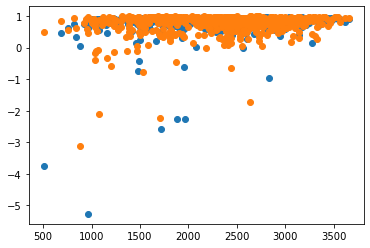

In [7]:
plt.scatter(DL_height, TCNN_r2.values())
plt.scatter(UA_height, UA_r2.values())


In [8]:
TCNN_r2_plot = np.array(list(TCNN_r2.values()))
TCNN_r2_plot[TCNN_r2_plot<-1]=-1
UA_r2_plot = np.array(list(UA_r2.values()))
UA_r2_plot[UA_r2_plot<-1]=-1
LSTM_r2_plot = np.array(list(LSTM_r2.values()))
LSTM_r2_plot[LSTM_r2_plot<-1]=-1
ATT_r2_plot = np.array(list(ATT_r2.values()))
ATT_r2_plot[ATT_r2_plot<-1]=-1

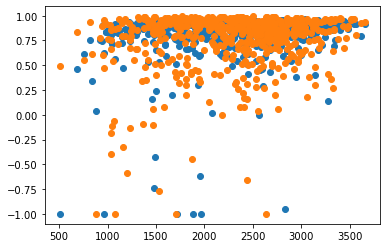

In [9]:
plt.scatter(DL_height, TCNN_r2_plot)
plt.scatter(UA_height, UA_r2_plot)

(array([  4.,  24.,  34.,  71.,  74.,  88., 120.,  97.,  49.,  20.]),
 array([ 510. ,  824.5, 1139. , 1453.5, 1768. , 2082.5, 2397. , 2711.5,
        3026. , 3340.5, 3655. ], dtype=float32),
 <BarContainer object of 10 artists>)

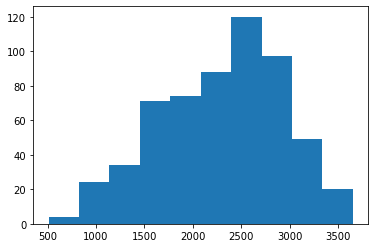

In [10]:
plt.hist(DL_height)

[ 510.  829. 1148. 1467. 1786. 2105. 2424. 2743. 3062. 3381. 3700.]
3655.0   510.0


(array([  4.,  25.,  36.,  71.,  78.,  96., 117.,  92.,  45.,  17.]),
 array([ 510.,  829., 1148., 1467., 1786., 2105., 2424., 2743., 3062.,
        3381., 3700.]),
 <BarContainer object of 10 artists>)

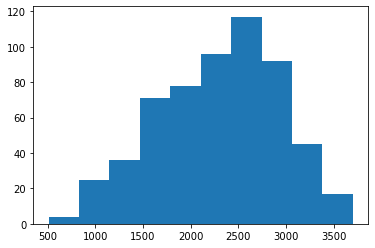

In [11]:
bins = np.linspace(510, 3700, 11)
print(bins)
print(np.max(DL_height), ' ', np.min(DL_height))
plt.hist(DL_height, bins)

In [12]:
total_count = np.zeros(10)
bad_count_TCNN = np.zeros(10)
bad_count_LSTM = np.zeros(10)
bad_count_ATT = np.zeros(10)
for i in range(581):
    ind = search_swe(DL_height[i], 0, 10, bins)
    # print(ind)
    total_count[ind]+=1
    # print(TCNN_r2[ind])
    if TCNN_r2_plot[i]<0.5:
        # print('oh')
        bad_count_TCNN[ind]+=1
    if LSTM_r2_plot[i]<0.5:
        bad_count_LSTM[ind]+=1
    if ATT_r2_plot[i]<0.5:
        bad_count_ATT[ind]+=1

In [13]:
total_count_UA = np.zeros(10)
bad_count_UA = np.zeros(10)
for i in range(580):
    ind = search_swe(UA_height[i], 0, 10, bins)
    total_count_UA[ind]+=1
    if UA_r2_plot[i]<0.5:
        bad_count_UA[ind]+=1

[ 1.  7.  7. 10. 12. 11. 14.  4.  7.  0.]


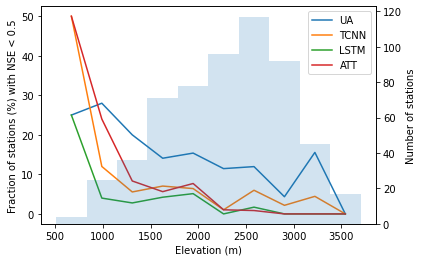

In [14]:
x = [(bins[i]+bins[i+1])/2 for i in range(10)]
(fig, ax) = plt.subplots()
ax2=ax.twinx()
ax.plot(x, bad_count_UA/total_count_UA*100, label='UA')
ax.plot(x, bad_count_TCNN/total_count*100, label='TCNN')
ax.plot(x, bad_count_LSTM/total_count*100, label='LSTM')
ax.plot(x, bad_count_ATT/total_count*100, label='ATT')
ax.legend()
ax2.hist(DL_height, bins, alpha=0.2)
ax.set_ylabel('Fraction of stations (%) with NSE < 0.5')
ax2.set_ylabel('Number of stations')
ax.set_xlabel('Elevation (m)')
print(bad_count_UA)

(0.2637663366908614, 1.0550784786575293e-10)


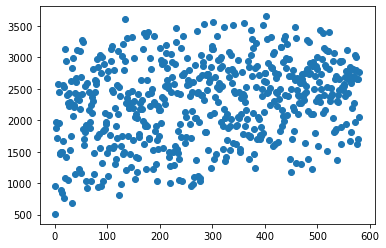

In [15]:
order = LSTM_r2_plot.argsort()
ranks = order.argsort()
plt.scatter(ranks, DL_height)
print(pearsonr(ranks, DL_height))

In [16]:
print(np.where(TCNN_r2_plot<=0)[0])
print(np.where(LSTM_r2_plot<=0)[0])
print(np.where(ATT_r2_plot<=0)[0])
print(DL_height[np.where(TCNN_r2_plot<=0)[0]])
print(DL_height[np.where(LSTM_r2_plot<=0)[0]])
print(DL_height[np.where(ATT_r2_plot<=0)[0]])
print(np.median(DL_height))

[ 91 130 155 214 400 426 476 508 535]
[ 91 214 400 508 535]
[ 91 227 341 400 426 508 535 550]
[1881. 1479. 1957.  510. 1970. 1492. 2832.  960. 1715.]
[1881.  510. 1970.  960. 1715.]
[1881. 1458.  885. 1970. 1492.  960. 1715. 2563.]
2389.0


[ 10  41  45  47  69 141 213 230 340 400 419 424 427 429 464 465 494]


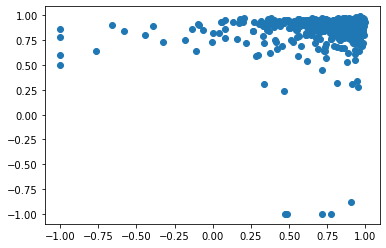

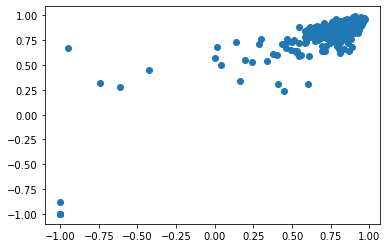

In [17]:
print(np.where(UA_r2_plot<=0)[0])
UA_r2_plot_same = np.insert(UA_r2_plot, 237, 0)
plt.scatter(UA_r2_plot_same, LSTM_r2_plot)
plt.show()
plt.scatter(TCNN_r2_plot, LSTM_r2_plot)

# MAX SWE

In [18]:
max_swe = swe.max(dim='time').data
UA_swe = np.delete(max_swe, 237)

In [19]:
print(max_swe[np.where(TCNN_r2_plot<=0)[0]])
print(max_swe[np.where(LSTM_r2_plot<=0)[0]])
print(max_swe[np.where(ATT_r2_plot<=0)[0]])
print(np.median(max_swe))
print(np.median(DL_height))
print(DL_height[np.where(TCNN_r2_plot<=0)[0]])
print(DL_height[np.where(LSTM_r2_plot<=0)[0]])
print(DL_height[np.where(ATT_r2_plot<=0)[0]])

[27.7  5.2 10.3  4.8 16.1  3.5 10.6  8.9  4.7]
[27.7  4.8 16.1  8.9  4.7]
[27.7 35.5  3.3 16.1  3.5  8.9  4.7  9.7]
25.0
2389.0
[1881. 1479. 1957.  510. 1970. 1492. 2832.  960. 1715.]
[1881.  510. 1970.  960. 1715.]
[1881. 1458.  885. 1970. 1492.  960. 1715. 2563.]


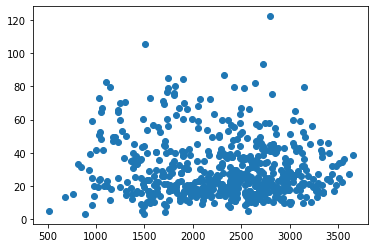

In [20]:
plt.scatter(DL_height, max_swe)
plt.show()

[  3.  15.  27.  39.  51.  63.  75.  87.  99. 111. 123.]


(array([ 81., 234., 115.,  76.,  36.,  22.,  14.,   1.,   1.,   1.]),
 array([  3.,  15.,  27.,  39.,  51.,  63.,  75.,  87.,  99., 111., 123.]),
 <BarContainer object of 10 artists>)

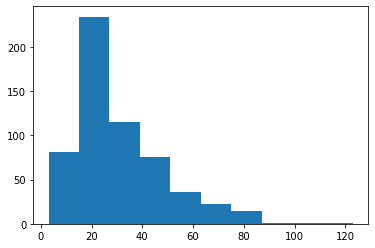

In [21]:
bins = np.linspace(3, 123, 11)
print(bins)
plt.hist(max_swe, bins)

In [22]:
total_count = np.zeros(10)
bad_count_TCNN = np.zeros(10)
bad_count_LSTM = np.zeros(10)
bad_count_ATT = np.zeros(10)
for i in range(581):
    ind = search_swe(max_swe[i], 0, 10, bins)
    # print(ind)
    total_count[ind]+=1
    # print(TCNN_r2[ind])
    if TCNN_r2_plot[i]<0.5:
        # print('oh')
        bad_count_TCNN[ind]+=1
    if LSTM_r2_plot[i]<0.5:
        bad_count_LSTM[ind]+=1
    if ATT_r2_plot[i]<0.5:
        bad_count_ATT[ind]+=1

In [23]:
total_count_UA = np.zeros(10)
bad_count_UA = np.zeros(10)
for i in range(580):
    ind = search_swe(UA_swe[i], 0, 10, bins)
    # print(ind)
    total_count_UA[ind]+=1
    if UA_r2_plot[i]<0.5:
        # print('oh')
        bad_count_UA[ind]+=1

[16. 30. 11.  3.  1.  7.  4.  1.  0.  0.]
[ 81. 233. 115.  76.  36.  22.  14.   1.   1.   1.]


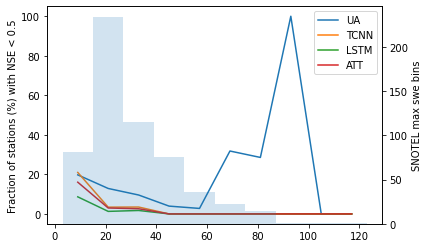

In [24]:
x = [(bins[i]+bins[i+1])/2 for i in range(10)]
(fig, ax) = plt.subplots()
ax2=ax.twinx()
ax.plot(x, bad_count_UA/total_count_UA*100, label='UA')
ax.plot(x, bad_count_TCNN/total_count*100, label='TCNN')
ax.plot(x, bad_count_LSTM/total_count*100, label='LSTM')
ax.plot(x, bad_count_ATT/total_count*100, label='ATT')
ax.legend()
ax2.hist(max_swe, bins, alpha=0.2)
ax.set_ylabel('Fraction of stations (%) with NSE < 0.5')
ax2.set_ylabel('SNOTEL max swe bins')
print(bad_count_UA)
print(total_count_UA)

[16. 30. 11.  3.  1.  7.  4.  1.  0.  0.]
[ 81. 233. 115.  76.  36.  22.  14.   1.   1.   1.]


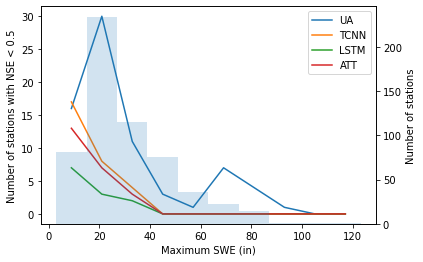

In [25]:
x = [(bins[i]+bins[i+1])/2 for i in range(10)]
(fig, ax) = plt.subplots()
ax2=ax.twinx()
ax.plot(x, bad_count_UA, label='UA')
ax.plot(x, bad_count_TCNN, label='TCNN')
ax.plot(x, bad_count_LSTM, label='LSTM')
ax.plot(x, bad_count_ATT, label='ATT')
ax.legend()
ax2.hist(max_swe, bins, alpha=0.2)
ax.set_ylabel('Number of stations with NSE < 0.5')
ax2.set_ylabel('Number of stations')
ax.set_xlabel('Maximum SWE (in)')
print(bad_count_UA)
print(total_count_UA)

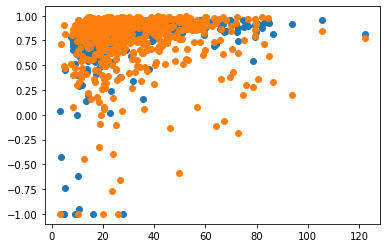

In [26]:
plt.scatter(max_swe, TCNN_r2_plot)
plt.scatter(UA_swe, UA_r2_plot)

# Lat Lon distance

In [27]:
latlon_dis = []
for i in range(581):
    station = data.isel(n_stations=i)
    lat = station.latitude.data
    lon = station.longitude.data
    abslat = np.abs(nsidc.lat - lat)
    latarg = np.where(abslat == np.min(abslat))[0][0]
    abslon = np.abs(nsidc.lon - lon)
    lonarg = np.where(abslon == np.min(abslon))[0][0]
    snotel_obs = swe[i]
    ua_pred = nsidc.isel(lat=latarg, lon=lonarg).data / 25.4  # mm to inch
    nan_id = np.where(np.isnan(snotel_obs))[0]
    snotel_obs = np.delete(snotel_obs, nan_id)
    ua_pred = np.delete(ua_pred, nan_id)
    nan_id = np.where(np.isnan(ua_pred))[0]
    snotel_obs = np.delete(snotel_obs, nan_id)
    ua_pred = np.delete(ua_pred, nan_id)
    if len(snotel_obs) < 2:
        print(i)
        continue
    else:
        latlon_dis.append(np.sqrt(np.min(abslon)*np.min(abslon)+np.min(abslat)*np.min(abslat)))

237


(580,)
0.0   0.028282221
[0.    0.003 0.006 0.009 0.012 0.015 0.018 0.021 0.024 0.027 0.03 ]


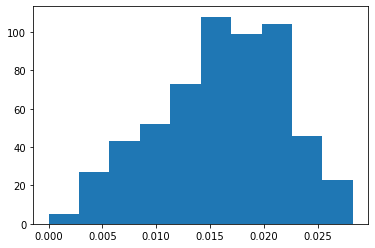

In [28]:
latlon_dis = np.array(latlon_dis)
print(latlon_dis.shape)
plt.hist(latlon_dis)
print(np.min(latlon_dis), ' ', np.max(latlon_dis))
bins = np.linspace(0, 0.03, 11)
print(bins)

In [29]:
total_count_UA = np.zeros(10)
bad_count_UA = np.zeros(10)
for i in range(580):
    ind = search_swe(latlon_dis[i], 0, 10, bins)
    # print(ind)
    total_count_UA[ind]+=1
    if UA_r2_plot[i]<0.5:
        # print('oh')
        bad_count_UA[ind]+=1

In [30]:
gridMET = xa.open_dataarray('gridMET/pr_1980_2018.nc')
grid_lon = gridMET.lon
grid_lat = gridMET.lat

In [31]:
latlon_dis_DL = []
for i in range(581):
    station = data.isel(n_stations=i)
    lat = station.latitude.data
    lon = station.longitude.data
    abslat = np.abs(grid_lat - lat)
    abslon = np.abs(grid_lon - lon)
    latlon_dis_DL.append(np.sqrt(np.min(abslon)*np.min(abslon)+np.min(abslat)*np.min(abslat)))

In [32]:
total_count = np.zeros(10)
bad_count_LSTM = np.zeros(10)
bad_count_TCNN = np.zeros(10)
bad_count_ATT = np.zeros(10)
DL_bins = bins.copy()
DL_bins[-1]=0.44
for i in range(581):
    ind = search_swe(latlon_dis_DL[i], 0, 10, DL_bins)
    total_count[ind]+=1
    if LSTM_r2_plot[i]<0.5:
        bad_count_LSTM[ind]+=1
    if TCNN_r2_plot[i]<0.5:
        bad_count_TCNN[ind]+=1
    if ATT_r2_plot[i]<0.5:
        bad_count_ATT[ind]+=1

[ 1.  1.  3.  4.  9. 16. 15. 12. 11.  1.]


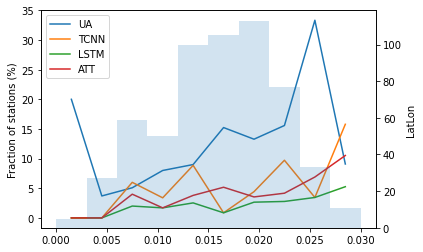

In [33]:
x = [(bins[i]+bins[i+1])/2 for i in range(10)]
(fig, ax) = plt.subplots()
ax2=ax.twinx()
ax.plot(x, bad_count_UA/total_count_UA*100, label='UA')
ax.plot(x, bad_count_TCNN/total_count*100, label='TCNN')
ax.plot(x, bad_count_LSTM/total_count*100, label='LSTM')
ax.plot(x, bad_count_ATT/total_count*100, label='ATT')
ax.legend()
ax2.hist(latlon_dis, bins, alpha=0.2)
ax.set_ylabel('Fraction of stations (%)')
ax2.set_ylabel('LatLon')
print(bad_count_UA)

[ 1.  1.  3.  4.  9. 16. 15. 12. 11.  1.]


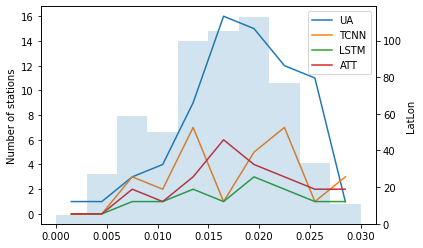

In [34]:
x = [(bins[i]+bins[i+1])/2 for i in range(10)]
(fig, ax) = plt.subplots()
ax2=ax.twinx()
ax.plot(x, bad_count_UA, label='UA')
ax.plot(x, bad_count_TCNN, label='TCNN')
ax.plot(x, bad_count_LSTM, label='LSTM')
ax.plot(x, bad_count_ATT, label='ATT')
ax.legend()
ax2.hist(latlon_dis, bins, alpha=0.2)
ax.set_ylabel('Number of stations')
ax2.set_ylabel('LatLon')
print(bad_count_UA)

* Both DL and UA dataset perform well with closer points. For DL it is because the forcing is more accurate, and for UA, the grid point will be more representative for the SNOTEL station.  
* All the models are better with more MAX SWE and higher elevation.  

# DAH

In [35]:
DL_dah = data.dah.data
print(DL_dah.shape)
UA_dah = np.delete(DL_dah, 237)
print(UA_dah.shape)

(581,)
(580,)


In [36]:
print(np.min(DL_dah), ' ', np.max(DL_dah))

-0.23333217   0.27911887


(array([  0.,   6.,  27.,  87., 186., 172.,  63.,  27.,  11.,   2.]),
 array([-0.3 , -0.24, -0.18, -0.12, -0.06,  0.  ,  0.06,  0.12,  0.18,
         0.24,  0.3 ]),
 <BarContainer object of 10 artists>)

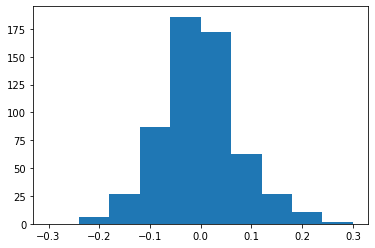

In [37]:
bins = np.linspace(-0.3, 0.3, 11)
plt.hist(DL_dah, bins)

In [38]:
total_count = np.zeros(10)
bad_count_TCNN = np.zeros(10)
bad_count_LSTM = np.zeros(10)
bad_count_ATT = np.zeros(10)
for i in range(581):
    ind = search_swe(DL_dah[i], 0, 10, bins)
    # print(ind)
    total_count[ind]+=1
    # print(TCNN_r2[ind])
    if TCNN_r2_plot[i]<0.5:
        # print('oh')
        bad_count_TCNN[ind]+=1
    if LSTM_r2_plot[i]<0.5:
        bad_count_LSTM[ind]+=1
    if ATT_r2_plot[i]<0.5:
        bad_count_ATT[ind]+=1
total_count_UA = np.zeros(10)
bad_count_UA = np.zeros(10)
for i in range(580):
    ind = search_swe(UA_dah[i], 0, 10, bins)
    # print(ind)
    total_count_UA[ind]+=1
    if UA_r2_plot[i]<0.5:
        # print('oh')
        bad_count_UA[ind]+=1

[ 0.  1.  4. 12. 20. 17. 11.  6.  2.  0.]
[  0.   6.  27.  87. 186. 171.  63.  27.  11.   2.]


/tempest/duan0000/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/tempest/duan0000/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/tempest/duan0000/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/tempest/duan0000/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


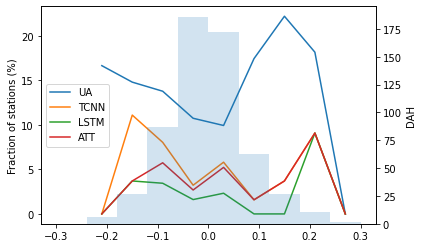

In [39]:
x = [(bins[i]+bins[i+1])/2 for i in range(10)]
(fig, ax) = plt.subplots()
ax2=ax.twinx()
ax.plot(x, bad_count_UA/total_count_UA*100, label='UA')
ax.plot(x, bad_count_TCNN/total_count*100, label='TCNN')
ax.plot(x, bad_count_LSTM/total_count*100, label='LSTM')
ax.plot(x, bad_count_ATT/total_count*100, label='ATT')
ax.legend()
ax2.hist(DL_dah, bins, alpha=0.2)
ax.set_ylabel('Fraction of stations (%)')
ax2.set_ylabel('DAH')
print(bad_count_UA)
print(total_count_UA)

[ 0.  1.  4. 12. 20. 17. 11.  6.  2.  0.]
[  0.   6.  27.  87. 186. 171.  63.  27.  11.   2.]


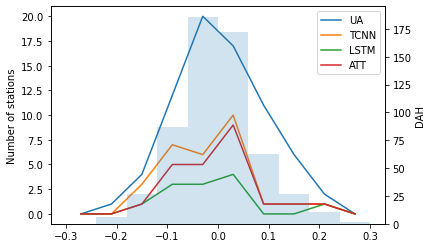

In [40]:
x = [(bins[i]+bins[i+1])/2 for i in range(10)]
(fig, ax) = plt.subplots()
ax2=ax.twinx()
ax.plot(x, bad_count_UA, label='UA')
ax.plot(x, bad_count_TCNN, label='TCNN')
ax.plot(x, bad_count_LSTM, label='LSTM')
ax.plot(x, bad_count_ATT, label='ATT')
ax.legend()
ax2.hist(DL_dah, bins, alpha=0.2)
ax.set_ylabel('Number of stations')
ax2.set_ylabel('DAH')
print(bad_count_UA)
print(total_count_UA)

# TRASP

In [41]:
DL_trasp = data.trasp.data
print(DL_trasp.shape)
UA_trasp = np.delete(DL_trasp, 237)
print(UA_trasp.shape)

(581,)
(580,)


In [42]:
print(np.min(DL_trasp), ' ', np.max(DL_trasp))

3.584978e-07   0.9999585


(array([128.,  55.,  51.,  48.,  36.,  34.,  37.,  39.,  38., 115.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

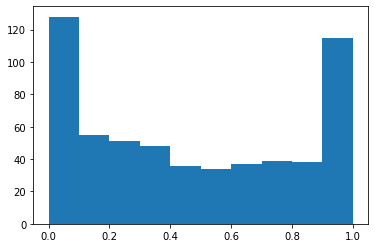

In [43]:
bins = np.linspace(0, 1, 11)
plt.hist(DL_trasp, bins)

In [44]:
total_count = np.zeros(10)
bad_count_TCNN = np.zeros(10)
bad_count_LSTM = np.zeros(10)
bad_count_ATT = np.zeros(10)
for i in range(581):
    ind = search_swe(DL_trasp[i], 0, 10, bins)
    # print(ind)
    total_count[ind]+=1
    # print(TCNN_r2[ind])
    if TCNN_r2_plot[i]<0.5:
        # print('oh')
        bad_count_TCNN[ind]+=1
    if LSTM_r2_plot[i]<0.5:
        bad_count_LSTM[ind]+=1
    if ATT_r2_plot[i]<0.5:
        bad_count_ATT[ind]+=1
total_count_UA = np.zeros(10)
bad_count_UA = np.zeros(10)
for i in range(580):
    ind = search_swe(UA_trasp[i], 0, 10, bins)
    # print(ind)
    total_count_UA[ind]+=1
    if UA_r2_plot[i]<0.5:
        # print('oh')
        bad_count_UA[ind]+=1

[17.  7.  4.  7.  2.  7.  2.  3.  6. 18.]
[128.  55.  51.  48.  36.  34.  36.  39.  38. 115.]


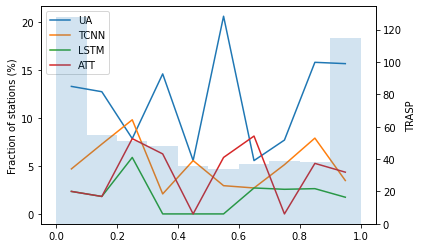

In [45]:
x = [(bins[i]+bins[i+1])/2 for i in range(10)]
(fig, ax) = plt.subplots()
ax2=ax.twinx()
ax.plot(x, bad_count_UA/total_count_UA*100, label='UA')
ax.plot(x, bad_count_TCNN/total_count*100, label='TCNN')
ax.plot(x, bad_count_LSTM/total_count*100, label='LSTM')
ax.plot(x, bad_count_ATT/total_count*100, label='ATT')
ax.legend()
ax2.hist(DL_trasp, bins, alpha=0.2)
ax.set_ylabel('Fraction of stations (%)')
ax2.set_ylabel('TRASP')
print(bad_count_UA)
print(total_count_UA)

[17.  7.  4.  7.  2.  7.  2.  3.  6. 18.]
[128.  55.  51.  48.  36.  34.  36.  39.  38. 115.]


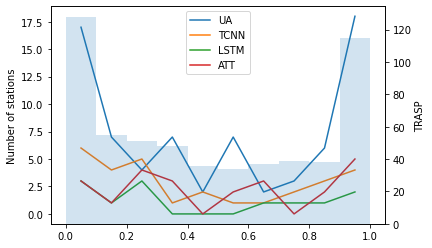

In [46]:
x = [(bins[i]+bins[i+1])/2 for i in range(10)]
(fig, ax) = plt.subplots()
ax2=ax.twinx()
ax.plot(x, bad_count_UA, label='UA')
ax.plot(x, bad_count_TCNN, label='TCNN')
ax.plot(x, bad_count_LSTM, label='LSTM')
ax.plot(x, bad_count_ATT, label='ATT')
ax.legend()
ax2.hist(DL_trasp, bins, alpha=0.2)
ax.set_ylabel('Number of stations')
ax2.set_ylabel('TRASP')
print(bad_count_UA)
print(total_count_UA)